In [1]:
# !pip install --upgrade numpy

# !pip install --upgrade sklearn
# !pip install lightgbm
# !pip uninstall tensorflow
# !pip install tensorflow


# INTRODUCTION

In [2]:
# Importing the libraries
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline
import csv


C:\Users\Abeer\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#  data = pd.read_csv('../sale_price_prediction_data.csv')


In [4]:
df = pd.read_csv("AmesHousing.tsv", sep="\t")
df

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,...,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,...,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,132000
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000


# Correlation Matrix

In [5]:
# corrmat = Data.corr()
# f, ax = plt.subplots(figsize=(20, 20))
# sns.set(font_scale=1.25)
# sns.heatmap(corrmat, annot = False, vmax=0.8, square=True, annot_kws={'size': 10},cmap = 'viridis');


In [6]:
def transform_features(df):
    
    feature_data = {"Feature": df.isnull().sum().keys().tolist(), "Missing Values": df.isnull().sum().values.tolist()}
    df_features = pd.DataFrame(feature_data)
    rows,cols = df.shape
    df_features['Percent Missing'] = 100*df_features['Missing Values']/rows
    features = df_features[df_features['Percent Missing'] > 5]['Feature'].tolist()
    df = df.drop(features, axis=1)
    
    text_feature_data = {"Feature": df.select_dtypes(include=['object']).isnull().sum().keys().tolist(), "Missing Values": df.select_dtypes(include=['object']).isnull().sum().values.tolist()}
    df_text_features = pd.DataFrame(text_feature_data)
    text_features = df_text_features[df_text_features['Missing Values'] > 0]['Feature'].tolist()
    df = df.drop(text_features, axis=1)
    
    numeric_dtypes_missing_values = df.select_dtypes(include=['int64','float64']).isnull().sum()
    numeric_features = numeric_dtypes_missing_values[numeric_dtypes_missing_values > 0]
    df = df.fillna(value=numeric_features)
    
    df['Years Since Remod'] = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = df['Yr Sold'] - df['Year Built']
    df = df.drop(['Year Built', 'Year Remod/Add'], axis=1)
    df = df.drop([1702,2180,2181], axis=0)
    df = df.drop(["Order","PID","Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)
    
    return df


def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    numerical_df = transform_df.select_dtypes(include=['int64', 'float64'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis=1)
    
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)

    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)
    
    return df

transform_df = transform_features(df)
filtered_df = select_features(transform_df)
print(len(filtered_df))

2927


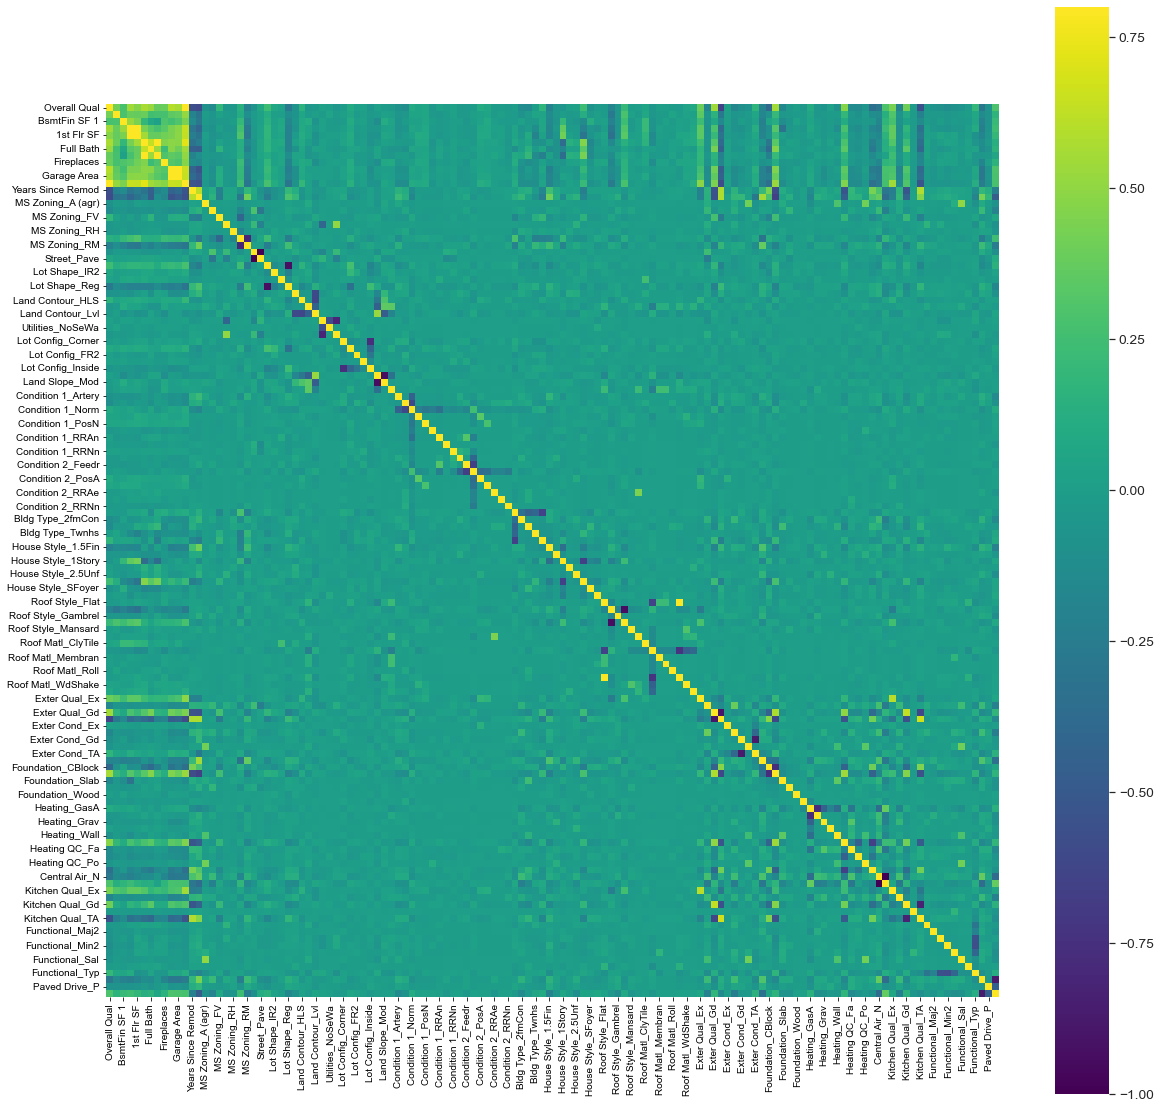

In [7]:
corrmat = filtered_df.corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.25)
sns.heatmap(corrmat, annot = False, vmax=0.8, square=True, annot_kws={'size': 10},cmap = 'viridis');


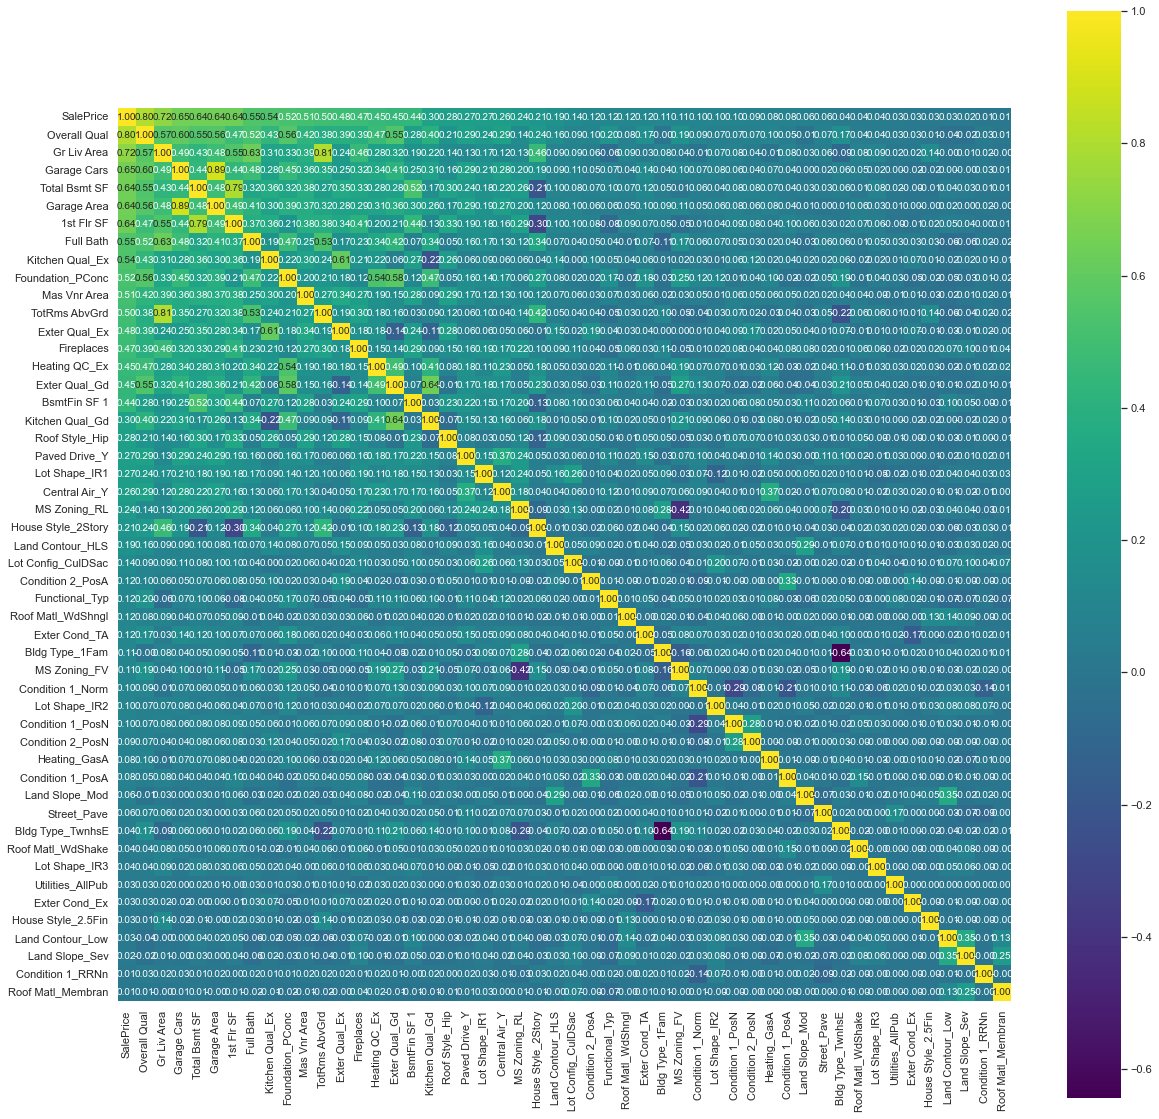

In [8]:
k = 50 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(filtered_df[cols].values.T)
plt.figure(figsize=(20, 20))

sns.set(font_scale=1.0)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values,cmap = 'viridis')
# plt.show()

In [9]:
key_features =list(filtered_df[cols].keys())
key_data = pd.DataFrame(filtered_df[key_features])


In [10]:
# sns.pairplot(key_data)
# plt.suptitle('Pairplot of Numeric Features', y=1.02)

# # SalePrice distribution
# plt.figure(figsize=(8, 6))
# sns.histplot(key_data['SalePrice'], kde=True)
# plt.title('Distribution of SalePrice')
# plt.xlabel('SalePrice')
# plt.show()


# Train Test Split

In [47]:
from sklearn.preprocessing import StandardScaler
# Spliting target variable and independent variables
X = key_data.drop(['SalePrice'], axis = 1)
y = key_data['SalePrice']
# Splitting to training and testing data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size = 0.3, random_state = 4)




# Linear Regression

In [12]:
print('------------Linear Regression-----------------')
# Import library for Linear Regression
from sklearn.linear_model import LinearRegression

# Create a Linear regressor
lm = LinearRegression()

# Train the model using the training sets
lm.fit(X_train, y_train)



------------Linear Regression-----------------


LinearRegression()

In [13]:
# #Converting the coefficient values to a dataframe
# coeffcients = pd.DataFrame([X_train.columns,lm.coef_]).T
# coeffcients = coeffcients.rename(columns={0: 'Attribute', 1: 'Coefficients'})


# Assuming y_true and y_pred are your true and predicted labels, respectively

# print(coeffcients)



In [14]:
import math
# Model prediction on train data
y_pred = lm.predict(X_train)

# # Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))
print('RMSE:',np.sqrt(sum((y_pred - y_train)**2) / len(y_pred)))
# Predicting Test data with the model
y_test_pred = lm.predict(X_test)
#Model Evaluation
acc_linreg = metrics.r2_score(y_test, y_test_pred)
mae_linreg = metrics.mean_absolute_error(y_test, y_test_pred)
rmse_linreg = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
rmse_linreg2 =  (rmse_linreg / (sum(y_test_pred)/len(y_test_pred))) 
print('R^2:', acc_linreg)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',mae_linreg)
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',rmse_linreg)
print('RMSE (Linear Regression): {:.2f}'.format(rmse_linreg2))

R^2: 0.8744734714966333
Adjusted R^2: 0.8713949930698741
MAE: 17881.59011885935
MSE: 761516090.0902854
RMSE: 27595.580988453305
RMSE: 27595.58098845329
R^2: 0.8779434447319372
Adjusted R^2: 0.8707290041913641
MAE: 19640.669600394504
MSE: 869390299.5955666
RMSE: 29485.42520628737
RMSE (Linear Regression): 0.16


In [15]:
data = {'y_test': y_test[:5], 'y_pred': y_pred[:5],'y_test-y_pred': y_test[:5]-y_pred[:5]}
df_results = pd.DataFrame(data)

# Display the DataFrame
print(df_results.head())


      y_test         y_pred  y_test-y_pred
2465  200825  226993.004656  -26168.004656
714   110000  330574.350919 -220574.350919
2905  164000  176669.065902  -12669.065902
2044  219000  114161.841292  104838.158708
672   153000  135119.150024   17880.849976


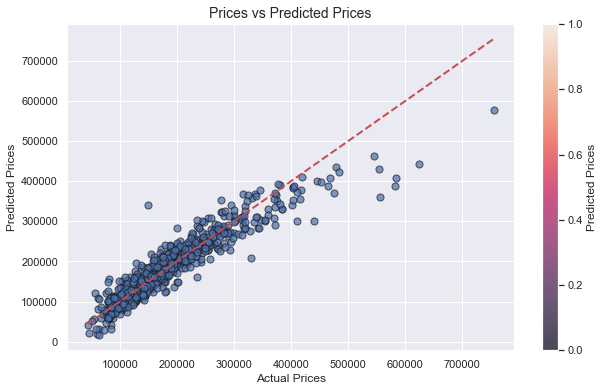

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
palette = sns.color_palette('coolwarm', as_cmap=True)

# Visualizing the differences between actual prices and predicted values
plt.figure(figsize=(10, 6))  # Adjusted figure size to match the original
plt.scatter(y_test, y_test_pred, alpha=0.7, cmap=palette, edgecolors='k', s=50)  # Added edgecolors and marker size
plt.xlabel("Actual Prices", fontsize=12)
plt.ylabel("Predicted Prices", fontsize=12)
plt.title("Prices vs Predicted Prices", fontsize=14)
plt.colorbar(label="Predicted Prices")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='r', linewidth=2)
plt.grid(True)
plt.show()


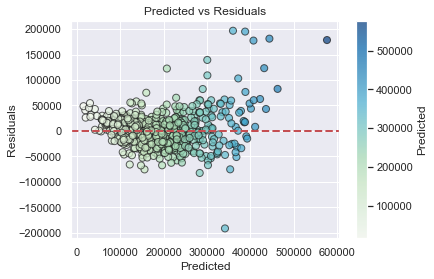

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a custom color palette resembling a cluster of dots
palette = sns.color_palette("GnBu", as_cmap=True)

# Checking residuals
plt.scatter(y_test_pred, y_test - y_test_pred, c=y_test_pred, cmap=palette, alpha=0.7, edgecolors='k', s=50)
plt.title("Predicted vs Residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals", labelpad=1.5)
plt.colorbar(label="Predicted")
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.show()

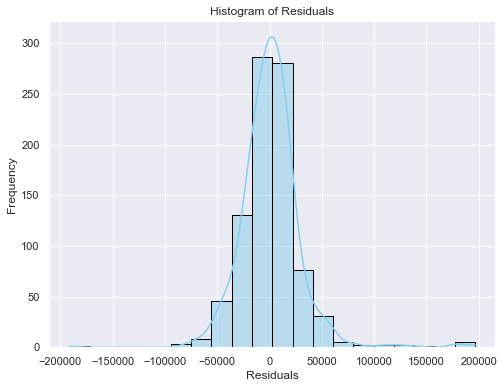

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a custom color palette
sns.set_palette("pastel")

# Checking Normality of errors using distplot
plt.figure(figsize=(8, 6))
sns.histplot(y_test - y_test_pred, kde=True, color='skyblue', bins=20, edgecolor='black')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# XG BOOST

In [76]:
print('------------XGBoost Regressor-----------------')
# Import XGBoost Regressor
from xgboost import XGBRegressor

#Create a XGBoost Regressor
reg = XGBRegressor()

# Train the model using the training sets
reg.fit(X_train, y_train)

# Model prediction on train data
y_pred = reg.predict(X_train)
print('------------Train Set-----------------')
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

#Predicting Test data with the model
y_test_pred = reg.predict(X_test)
print('------------Test Set-----------------')
# Model Evaluation
acc_xgb = metrics.r2_score(y_test, y_test_pred)
mae_xgb = metrics.mean_absolute_error(y_test, y_test_pred)
rmse_xgb = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
rmse_xgb2 =  (rmse_xgb / (sum(y_test)/len(y_test)))
print('R^2:', acc_xgb)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',mae_xgb)
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',rmse_xgb)
print('RMSE (XG Boost): {:.2f}'.format(rmse_xgb2))


------------XGBoost Regressor-----------------
------------Train Set-----------------
R^2: 0.9961137882361147
Adjusted R^2: 0.9960184807404039
MAE: 3512.1526308059692
MSE: 23575994.835365847
RMSE: 4855.511799529051
------------Test Set-----------------
R^2: 0.8962591765639408
Adjusted R^2: 0.8901273305466104
MAE: 17762.726229202217
MSE: 738930124.3942746
RMSE: 27183.269199900784
RMSE (XG Boost): 0.15


In [69]:
print('------------XGBoost Regressor-----------------')

# Import XGBoost Regressor
from xgboost import XGBRegressor

# Define the hyperparameters to iterate over
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.001, 0.0001],
    'n_estimators': [100, 500, 1000, 2000],
    'missing': [np.nan],
    'objective': ['reg:squarederror'],
    'reg_lambda': [0, 1, 10],
}


# create XGBoost regressor
model = XGBRegressor(
#     tree_method='gpu_hist',
    verbosity=0,
    # reg_lambda=1
)

# perform grid search using 5-fold cross-validation
grid_search = GridSearchCV( estimator=model, param_grid=param_grid,scoring='neg_mean_squared_error',cv=5, n_jobs=-1
)

# fit the model to the training data
grid_search.fit(X_train, y_train)

# get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
y_pred = best_model.predict(X_train)
print('------------Train Set-----------------')
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

# make predictions on the test data
y_pred = best_model.predict(X_test)

# evaluate the model on the test data
acc_xgb = metrics.r2_score(y_test, y_pred)
mae_xgb = metrics.mean_absolute_error(y_test, y_pred)
rmse_xgb = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
rmse_xgb2 = (rmse_xgb / (sum(y_test) / len(y_test)))

# print the results
print('------------Test Set-----------------')
print('R^2:', acc_xgb)
print('Adjusted R^2:', 1 - (1 - metrics.r2_score(y_test, y_pred)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))
print('MAE:', mae_xgb)
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', rmse_xgb)
print('RMSE (XG Boost): {:.2f}'.format(rmse_xgb2))
print("Best Hyperparameters:", best_params)

------------XGBoost Regressor-----------------
------------Train Set-----------------
R^2: 0.9570827031881153
Adjusted R^2: 0.9560301768899259
MAE: 11718.932765007019
MSE: 260360996.63629416
RMSE: 16135.705644200818
------------Test Set-----------------
R^2: 0.9124343152811151
Adjusted R^2: 0.9072585389828939
MAE: 16678.661880510524
MSE: 623717068.7379061
RMSE: 24974.32819392558
RMSE (XG Boost): 0.14
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'missing': nan, 'n_estimators': 2000, 'objective': 'reg:squarederror', 'reg_lambda': 1}


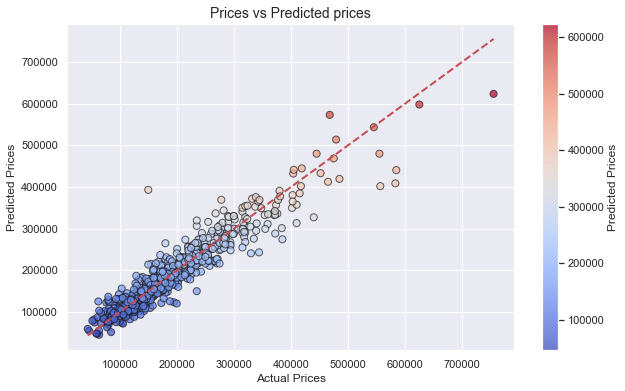

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a custom color palette
palette = sns.color_palette('coolwarm', as_cmap=True)

# Visualize the differences between actual prices and predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, c=y_test_pred, cmap=palette, alpha=0.7, edgecolors='k', s=50)
plt.xlabel("Actual Prices", fontsize=12)
plt.ylabel("Predicted Prices", fontsize=12)
plt.title("Prices vs Predicted prices", fontsize=14)
plt.colorbar(label="Predicted Prices")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='r', linewidth=2)
plt.grid(True)
plt.show()


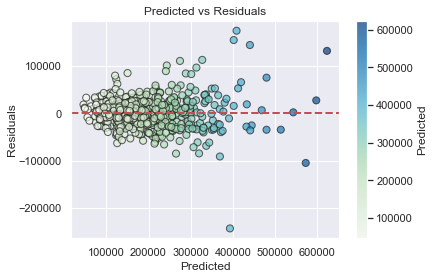

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a custom color palette resembling a cluster of dots
palette = sns.color_palette("GnBu", as_cmap=True)

# Checking residuals
plt.scatter(y_test_pred, y_test - y_test_pred, c=y_test_pred, cmap=palette, alpha=0.7, edgecolors='k', s=50)
plt.title("Predicted vs Residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals", labelpad=1.5)
plt.colorbar(label="Predicted")
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.show()


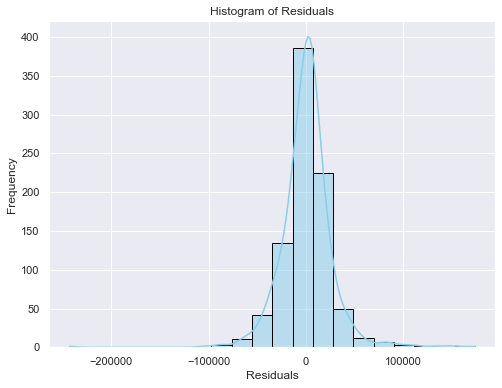

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a custom color palette
sns.set_palette("pastel")

# Checking Normality of errors using distplot
plt.figure(figsize=(8, 6))
sns.histplot(y_test - y_test_pred, kde=True, color='skyblue', bins=20, edgecolor='black')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


<Figure size 432x288 with 0 Axes>

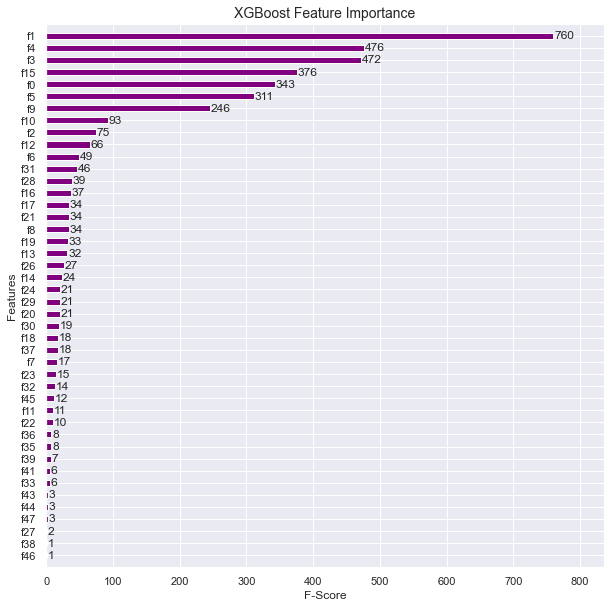

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance

# Set a custom color palette
sns.set_palette("GnBu")

# Create a figure and axis
plt.clf()
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the importance chart
plot_importance(reg, height=0.5, max_num_features=50, ax=ax, color='purple')

# Customize labels and title
plt.xlabel("F-Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("XGBoost Feature Importance", fontsize=14)

# Show the plot
plt.show()


# SVM

In [77]:
print('------------SVR-----------------')
# Import SVR
from sklearn.svm import SVR

# Create an SVR model
svr_regressor = SVR(kernel='rbf')  # 'rbf' kernel is commonly used

# Train the model using the training sets
svr_regressor.fit(X_train_scaled, y_train)

# Model prediction on train data
y_train_SVR_pred = svr_regressor.predict(X_train_scaled)
print('------------Train Set-----------------')
# Model Evaluation for training set
print('R^2:', metrics.r2_score(y_train, y_train_SVR_pred))
print('MAE:', metrics.mean_absolute_error(y_train, y_train_SVR_pred))
print('MSE:', metrics.mean_squared_error(y_train, y_train_SVR_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_train_SVR_pred)))

# Predicting Test data with the model
y_test_SVR_pred = svr_regressor.predict(X_test_scaled)
print('------------Test Set-----------------')
# Model Evaluation for test set
acc_svr = metrics.r2_score(y_test, y_test_SVR_pred)
mae_svr = metrics.mean_absolute_error(y_test, y_test_SVR_pred)
rmse_svr = np.sqrt(metrics.mean_squared_error(y_test, y_test_SVR_pred))
rmse_svr2 = (rmse_svr / (sum(y_test) / len(y_test)))

print('R^2:', acc_svr)
print('MAE:', mae_svr)
print('MSE:', metrics.mean_squared_error(y_test, y_test_SVR_pred))
print('RMSE:', rmse_svr)
print('RMSE (SVR): {:.2f}'.format(rmse_svr2))


------------SVR-----------------
------------Train Set-----------------
R^2: -0.06585101718676833
MAE: 54963.713112374455
MSE: 6466065053.37278
RMSE: 80411.846474091
------------Test Set-----------------
R^2: -0.06304870989406419
MAE: 58323.59562407732
MSE: 7571934455.709711
RMSE: 87016.86305371913
RMSE (SVR): 0.48


In [83]:
print('------------SVR-----------------')

# Import SVR
from sklearn.svm import SVR

# Define the hyperparameters to iterate over
param_grid = {
    'kernel': ['linear', 'rbf','poly'],
    'C': [0.1, 1, 10, 20, 50, 100, 200, 500],
    'gamma': [0.01, 0.001, 0.001]
}

# Create SVR regressor
model = SVR()

# Perform grid search using 5-fold cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Model prediction on train data
y_train_SVR_pred = best_model.predict(X_train_scaled)
print('------------Train Set-----------------')
# Model Evaluation for training set
print('R^2:', metrics.r2_score(y_train, y_train_SVR_pred))
print('MAE:', metrics.mean_absolute_error(y_train, y_train_SVR_pred))
print('MSE:', metrics.mean_squared_error(y_train, y_train_SVR_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_train_SVR_pred)))

# Predicting Test data with the model
y_test_SVR_pred = best_model.predict(X_test_scaled)
print('------------Test Set-----------------')
# Model Evaluation for test set
acc_svr = metrics.r2_score(y_test, y_test_SVR_pred)
mae_svr = metrics.mean_absolute_error(y_test, y_test_SVR_pred)
rmse_svr = np.sqrt(metrics.mean_squared_error(y_test, y_test_SVR_pred))
rmse_svr2 = (rmse_svr / (sum(y_test) / len(y_test)))

# Print the results
print('R^2:', acc_svr)
print('MAE:', mae_svr)
print('MSE:', metrics.mean_squared_error(y_test, y_test_SVR_pred))
print('RMSE:', rmse_svr)
print('RMSE (SVR): {:.2f}'.format(rmse_svr2))
print("Best Hyperparameters:", best_params)


------------SVR-----------------
------------Train Set-----------------
R^2: 0.8645194525049709
MAE: 17107.580809131316
MSE: 821902892.0961418
RMSE: 28668.848810095984
------------Test Set-----------------
R^2: 0.8783504883213731
MAE: 18975.073163763773
MSE: 866490989.9485686
RMSE: 29436.219015841158
RMSE (SVR): 0.16
Best Hyperparameters: {'C': 500, 'gamma': 0.01, 'kernel': 'linear'}


# Neural Network

In [35]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Function to create a model for KerasRegressor
def create_model(units=32, activation='relu'):
    model = Sequential()
    model.add(Dense(units=units, activation=activation, input_dim=X_train.shape[1]))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Define the hyperparameters to iterate over
hyperparameters = {
    'units': [32, 64, 128],  # Number of units in the hidden layer
    'epochs': [50, 100],  # Number of training epochs
    'batch_size': [32, 64],  # Batch size for training
    'activation': ['relu', 'sigmoid']  # Activation functions for the hidden layer
}

# Create a KerasRegressor using the create_model function
keras_regressor = KerasRegressor(build_fn=create_model, verbose=0)

# Create a grid search object
grid_search = GridSearchCV(estimator=keras_regressor, param_grid=hyperparameters, cv=5)

# Train the model using the grid search object
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train a model using the best hyperparameters
best_model = create_model(**best_params)
best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

# Predict using the best model
y_pred_best_model = best_model.predict(X_train)

# Model evaluation on train data using the best model
mse_train_best_model = metrics.mean_squared_error(y_train, y_pred_best_model)
rmse_train_best_model = np.sqrt(mse_train_best_model)

# Predict on the test data using the best model
y_test_pred_best_model = best_model.predict(X_test)

# Model evaluation on test data using the best model
mse_test_best_model = metrics.mean_squared_error(y_test, y_test_pred_best_model)
rmse_test_best_model = np.sqrt(mse_test_best_model)
rmse_test_normalized_best_model = rmse_test_best_model / (sum(y_test) / len(y_test))

print('Best Hyperparameters:', best_params)
print('Train RMSE (Best Model):', rmse_train_best_model)
print('Test RMSE (Best Model):', rmse_test_best_model)
print('Test RMSE (Normalized) (Best Model):', rmse_test_normalized_best_model)


ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
palette = sns.color_palette('viridis')

# Visualizing the differences between actual prices and predicted values

# Create a custom color palette
palette = sns.color_palette('coolwarm', as_cmap=True)

# Visualize the differences between actual prices and predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, c=y_test_pred, cmap=palette, alpha=0.7, edgecolors='k', s=50)
plt.xlabel("Actual Prices", fontsize=12)
plt.ylabel("Predicted Prices", fontsize=12)
plt.title("Prices vs Predicted prices", fontsize=14)
plt.colorbar(label="Predicted Prices")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.grid(True)
plt.show()

# Checking residuals

palette = sns.color_palette("GnBu", as_cmap=True)

# Checking residuals
plt.scatter(y_test_pred, y_test - y_test_pred, c=y_test_pred, cmap=palette, alpha=0.7, edgecolors='k', s=50)
plt.title("Predicted vs Residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals", labelpad=1.5)
plt.colorbar(label="Predicted")
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.show()

# Checking Normality of errors using distplot
plt.figure(figsize=(8, 6))
sns.histplot(y_test - y_test_pred, kde=True, color='skyblue', bins=20, edgecolor='black')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


## Random Forrest Regressor

In [56]:
print('------------Random Forest Regressor-----------------')

# Import Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor
reg_rf = RandomForestRegressor(random_state=4)

# Train the model using the training sets
reg_rf.fit(X_train, y_train)

# Model prediction on train data
y_pred_rf_train = reg_rf.predict(X_train)
print('------------Train Set-----------------')
# Model Evaluation for training set
print('R^2:', metrics.r2_score(y_train, y_pred_rf_train))
print('Adjusted R^2:', 1 - (1 - metrics.r2_score(y_train, y_pred_rf_train)) * (len(y_train) - 1) / (len(y_train) - X_train.shape[1] - 1))
print('MAE:', metrics.mean_absolute_error(y_train, y_pred_rf_train))
print('MSE:', metrics.mean_squared_error(y_train, y_pred_rf_train))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_rf_train)))

# Predicting Test data with the model
y_pred_rf_test = reg_rf.predict(X_test)
print('------------Test Set-----------------')
# Model Evaluation for test set
acc_rf = metrics.r2_score(y_test, y_pred_rf_test)
mae_rf = metrics.mean_absolute_error(y_test, y_pred_rf_test)
rmse_rf = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf_test))
rmse_rf2 =  (rmse_rf / (sum(y_pred_rf_test)/len(y_pred_rf_test)))
print('R^2:', acc_rf)
print('Adjusted R^2:', 1 - (1 - metrics.r2_score(y_test, y_pred_rf_test)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))
print('MAE:', mae_rf)
print('MSE:', metrics.mean_squared_error(y_test, y_pred_rf_test))
print('RMSE:', rmse_rf)
print('RMSE:', rmse_rf2)


------------Random Forest Regressor-----------------
------------Train Set-----------------
R^2: 0.9819198676557807
Adjusted R^2: 0.9814764610066982
MAE: 6379.029184163412
MSE: 109684477.49844041
RMSE: 10473.035734611069
------------Test Set-----------------
R^2: 0.8815322878559881
Adjusted R^2: 0.8745299743516979
MAE: 18156.359256731135
MSE: 843827515.2619625
RMSE: 29048.70935621689
RMSE: 0.16060444877496735


In [57]:
print('------------Random Forest Regressor-----------------')

# Import Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import numpy as np

# Define the hyperparameters to iterate over
param_grid = {
    'n_estimators': [50, 80, 100,500],
    'max_depth': [3, 5, 7,12],
    'min_samples_leaf': [1, 2, 4,6,8,12],
    'bootstrap': [True, False]
}

# Create a Random Forest Regressor
reg_rf = RandomForestRegressor(random_state=4)

# Create a grid search object
grid_search = GridSearchCV(estimator=reg_rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Train the model using the grid search object
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

# Model prediction on train data using the best model
y_pred_rf_train = best_rf_model.predict(X_train)
print('------------Train Set-----------------')
# Model Evaluation for training set
print('R^2:', metrics.r2_score(y_train, y_pred_rf_train))
print('Adjusted R^2:', 1 - (1 - metrics.r2_score(y_train, y_pred_rf_train)) * (len(y_train) - 1) / (len(y_train) - X_train.shape[1] - 1))
print('MAE:', metrics.mean_absolute_error(y_train, y_pred_rf_train))
print('MSE:', metrics.mean_squared_error(y_train, y_pred_rf_train))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_rf_train)))

# Predicting Test data with the best model
y_pred_rf_test = best_rf_model.predict(X_test)
print('------------Test Set-----------------')
# Model Evaluation for test set
acc_rf = metrics.r2_score(y_test, y_pred_rf_test)
mae_rf = metrics.mean_absolute_error(y_test, y_pred_rf_test)
rmse_rf = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf_test))
rmse_rf2 = (rmse_rf / (sum(y_pred_rf_test) / len(y_pred_rf_test)))
print('R^2:', acc_rf)
print('Adjusted R^2:', 1 - (1 - metrics.r2_score(y_test, y_pred_rf_test)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))
print('MAE:', mae_rf)
print('MSE:', metrics.mean_squared_error(y_test, y_pred_rf_test))
print('RMSE:', rmse_rf)
print('RMSE (Normalized):', rmse_rf2)

# Print the best hyperparameters and the corresponding evaluation metrics
print("Best Hyperparameters:", best_params)

------------Random Forest Regressor-----------------
------------Train Set-----------------
R^2: 0.9689730245759809
Adjusted R^2: 0.9682121027562727
MAE: 8451.5131394501
MSE: 188227471.0687368
RMSE: 13719.601709551804
------------Test Set-----------------
R^2: 0.878058229071694
Adjusted R^2: 0.8708505731302139
MAE: 18077.83729464695
MSE: 868572708.1822189
RMSE: 29471.55761377771
RMSE (Normalized): 0.16279736091749897
Best Hyperparameters: {'bootstrap': True, 'max_depth': 12, 'min_samples_leaf': 2, 'n_estimators': 500}


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
palette = sns.color_palette('viridis')

# Visualizing the differences between actual prices and predicted values

# Create a custom color palette
palette = sns.color_palette('coolwarm', as_cmap=True)

# Visualize the differences between actual prices and predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf_test, c=y_test_pred, cmap=palette, alpha=0.7, edgecolors='k', s=50)
plt.xlabel("Actual Prices", fontsize=12)
plt.ylabel("Predicted Prices", fontsize=12)
plt.title("Prices vs Predicted prices", fontsize=14)
plt.colorbar(label="Predicted Prices")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.grid(True)
plt.show()

# Checking residuals

palette = sns.color_palette("GnBu", as_cmap=True)

# Checking residuals
plt.scatter(y_test_pred, y_test - y_pred_rf_test, c=y_test_pred, cmap=palette, alpha=0.7, edgecolors='k', s=50)
plt.title("Predicted vs Residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals", labelpad=1.5)
plt.colorbar(label="Predicted")
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.show()

# Checking Normality of errors using distplot
plt.figure(figsize=(8, 6))
sns.histplot(y_test - y_pred_rf_test, kde=True, color='skyblue', bins=20, edgecolor='black')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


# Voting Regressior

In [ ]:
print('------------Voting Regressor-----------------')

# Import necessary libraries for ensemble models
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# Create the sub-models
estimators = [
    ('linear', LinearRegression()),
    ('tree', DecisionTreeRegressor(random_state=4)),
    ('random_forest', RandomForestRegressor(random_state=4))  # Added Random Forest Regressor
]


# Create the Voting Regressor
voting_reg = VotingRegressor(estimators)

# Train the model using the training sets
voting_reg.fit(X_train, y_train)

# Model prediction on train data
y_pred_voting_train = voting_reg.predict(X_train)
print('------------Train Set-----------------')
# Model Evaluation for training set
print('R^2:', metrics.r2_score(y_train, y_pred_voting_train))
print('MAE:', metrics.mean_absolute_error(y_train, y_pred_voting_train))
print('MSE:', metrics.mean_squared_error(y_train, y_pred_voting_train))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_voting_train)))

# Predicting Test data with the model
y_pred_voting_test = voting_reg.predict(X_test)
print('------------Test Set-----------------')
# Model Evaluation for test set
acc_voting = metrics.r2_score(y_test, y_pred_voting_test)
mae_voting = metrics.mean_absolute_error(y_test, y_pred_voting_test)
rmse_voting = np.sqrt(metrics.mean_squared_error(y_test, y_pred_voting_test))
print('R^2:', acc_voting)
print('MAE:', mae_voting)
print('MSE:', metrics.mean_squared_error(y_test, y_pred_voting_test))
print('RMSE:', rmse_voting)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
palette = sns.color_palette('viridis')

# Visualizing the differences between actual prices and predicted values

# Create a custom color palette
palette = sns.color_palette('coolwarm', as_cmap=True)

# Visualize the differences between actual prices and predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, c=y_pred_voting_test, cmap=palette, alpha=0.7, edgecolors='k', s=50)
plt.xlabel("Actual Prices", fontsize=12)
plt.ylabel("Predicted Prices", fontsize=12)
plt.title("Prices vs Predicted prices", fontsize=14)
plt.colorbar(label="Predicted Prices")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.grid(True)
plt.show()

# Checking residuals

palette = sns.color_palette("GnBu", as_cmap=True)

# Checking residuals
plt.scatter(y_test_pred, y_test - y_pred_voting_test, c=y_test_pred, cmap=palette, alpha=0.7, edgecolors='k', s=50)
plt.title("Predicted vs Residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals", labelpad=1.5)
plt.colorbar(label="Predicted")
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.show()

# Checking Normality of errors using distplot
plt.figure(figsize=(8, 6))
sns.histplot(y_test - y_pred_voting_test, kde=True, color='skyblue', bins=20, edgecolor='black')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


# Light GBM Regressor

In [ ]:
print('------------LightGBM Regressor-----------------')

# Import LightGBM Regressor
import lightgbm as lgb

# Create a LightGBM Regressor
lgb_reg = lgb.LGBMRegressor(random_state=4)

# Train the model using the training sets
lgb_reg.fit(X_train, y_train)

# Model prediction on train data
y_pred_lgb_train = lgb_reg.predict(X_train)
print('------------Train Set-----------------')
# Model Evaluation for training set
print('R^2:', metrics.r2_score(y_train, y_pred_lgb_train))
print('MAE:', metrics.mean_absolute_error(y_train, y_pred_lgb_train))
print('MSE:', metrics.mean_squared_error(y_train, y_pred_lgb_train))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_lgb_train)))

# Predicting Test data with the model
y_pred_lgb_test = lgb_reg.predict(X_test)
print('------------Test Set-----------------')
# Model Evaluation for test set
acc_lgb = metrics.r2_score(y_test, y_pred_lgb_test)
mae_lgb = metrics.mean_absolute_error(y_test, y_pred_lgb_test)
rmse_lgb = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lgb_test))
rmse_lgb2 =  (rmse_rf / (sum(y_pred_lgb_test)/len(y_pred_lgb_test)))
print('R^2:', acc_lgb)
print('MAE:', mae_lgb)
print('MSE:', metrics.mean_squared_error(y_test, y_pred_lgb_test))
print('RMSE:', rmse_lgb)
print('RMSE:', rmse_lgb2)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
palette = sns.color_palette('viridis')

# Visualizing the differences between actual prices and predicted values

# Create a custom color palette
palette = sns.color_palette('coolwarm', as_cmap=True)

# Visualize the differences between actual prices and predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, c=y_pred_lgb_test, cmap=palette, alpha=0.7, edgecolors='k', s=50)
plt.xlabel("Actual Prices", fontsize=12)
plt.ylabel("Predicted Prices", fontsize=12)
plt.title("Prices vs Predicted prices", fontsize=14)
plt.colorbar(label="Predicted Prices")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.grid(True)
plt.show()

# Checking residuals

palette = sns.color_palette("GnBu", as_cmap=True)

# Checking residuals
plt.scatter(y_test_pred, y_test - y_pred_lgb_test, c=y_test_pred, cmap=palette, alpha=0.7, edgecolors='k', s=50)
plt.title("Predicted vs Residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals", labelpad=1.5)
plt.colorbar(label="Predicted")
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.show()

# Checking Normality of errors using distplot
plt.figure(figsize=(8, 6))
sns.histplot(y_test - y_pred_lgb_test, kde=True, color='skyblue', bins=20, edgecolor='black')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


In [85]:
# data = {
#     'Model': ['Linear Regression', 'XGBoost', 'SVM'],
#     'Train MAE': [mae_train_lr, mae_train_xgb, mae_train_svm],
#     'Train MSE': [mse_train_lr, mse_train_xgb, mse_train_svm],
#     'Train RMSE': [rmse_train_lr, rmse_train_xgb, rmse_train_svm],
#     'Train R^2': [r2_train_lr, r2_train_xgb, r2_train_svm],
#     'Test MAE': [mae_test_lr, mae_test_xgb, mae_test_svm],
#     'Test MSE': [mse_test_lr, mse_test_xgb, mse_test_svm],
#     'Test RMSE': [rmse_test_lr, rmse_test_xgb, rmse_test_svm],
#     'Test R^2': [r2_test_lr, r2_test_xgb, r2_test_svm]
# }

# # Create a DataFrame
# df = pd.DataFrame(data)

# # Set the model names as the index
# df.set_index('Model', inplace=True)

# # Plot the Seaborn table
# plt.figure(figsize=(10, 6))
# sns.heatmap(df, annot=True, fmt='.4f', cmap='YlGnBu', cbar=False)
# plt.title('Model Evaluation Metrics')
# plt.show()
